Before SMOTE: [15505  2577]
After SMOTE: [15505 15505]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1 - Accuracy: 0.6932 | Loss: 0.5704 | F1 Score: 0.6847
Epoch 2 - Accuracy: 0.7783 | Loss: 0.4578 | F1 Score: 0.7257
Epoch 3 - Accuracy: 0.7894 | Loss: 0.4382 | F1 Score: 0.7413
Epoch 4 - Accuracy: 0.6974 | Loss: 0.4956 | F1 Score: 0.7419
Epoch 5 - Accuracy: 0.8026 | Loss: 0.4248 | F1 Score: 0.7758
Epoch 6 - Accuracy: 0.7885 | Loss: 0.4344 | F1 Score: 0.7381
Epoch 7 - Accuracy: 0.7973 | Loss: 0.4226 | F1 Score: 0.7553
Epoch 8 - Accuracy: 0.7978 | Loss: 0.4280 | F1 Score: 0.7812
Epoch 9 - Accuracy: 0.8031 | Loss: 0.4186 | F1 Score: 0.7712
Epoch 10 - Accuracy: 0.7986 | Loss: 0.4203 | F1 Score: 0.7585

✅ Best Model from Epoch 8 with F1 Score: 0.7812

✅ Verified F1 Score with Best Predictions: 0.7812
✅ Best Model from Epoch 8 with F1 Score: 0.7812

📊 Final Test Classification Report:

              precision    recall  f1-score   support

  non-damage       0.76      0.87      0.81      3101
      damage       0.85      0.72      0.78      3101

    accuracy                           

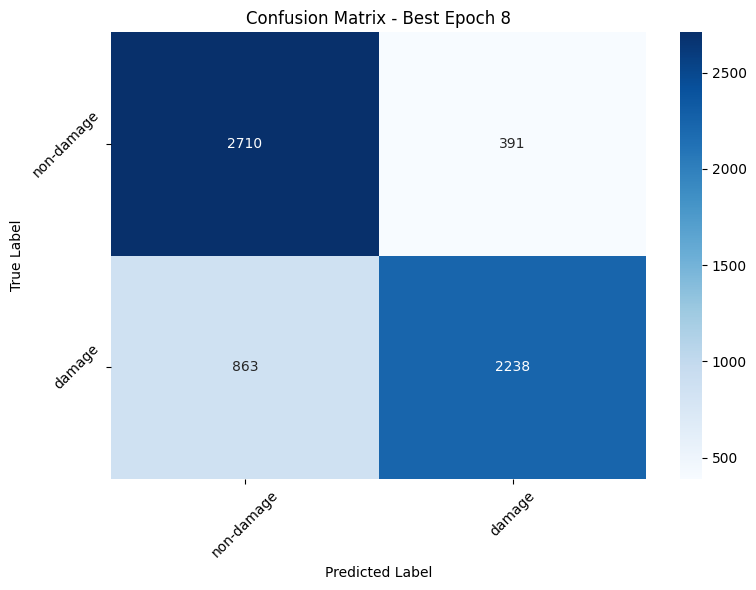

✅ Model saved to /kaggle/working/best_cnn_tfidf_model.h5
Saved artifact at '/tmp/tmpvy2q_n1o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5000, 1), dtype=tf.float32, name='keras_tensor_104')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138119001247568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001245840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001246416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001245072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001244304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001244880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119001243920: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model converted and saved to /kaggle/working/best_cnn(Binary)_tfidf_model.tflite


W0000 00:00:1747745246.008778      91 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747745246.008804      91 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [9]:
# ========== Imports ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess Labels ==========
df["Binary_class"] = df["Binary_class"].astype(str).str.strip().str.lower().map({"damage": 1, "non-damage": 0})
df["Processed_data"] = df["Processed_data"].fillna("")

# ========== TF-IDF Vectorizer ==========
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Processed_data"]).toarray()
y = df["Binary_class"].values

# ========== Apply SMOTE to Full Data ==========
print("Before SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE:", np.bincount(y_smote))

# ========== Train-Test Split AFTER SMOTE ==========
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# ========== Reshape for CNN ==========
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# ========== Build CNN Model ==========
model = models.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ========== Custom Callback to Track Best F1 on Test Set ==========
class TestF1Callback(callbacks.Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_weights = None
        self.best_epoch = 0
        self.best_predictions = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_test, verbose=0).ravel()
        y_pred = (y_pred_probs > 0.5).astype(int)

        acc = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)  # Binary F1 score
        loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)[0]

        print(f"Epoch {epoch+1} - Accuracy: {acc:.4f} | Loss: {loss:.4f} | F1 Score: {f1:.4f}")

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_weights = self.model.get_weights().copy()  # Copy weights to avoid reference issues
            self.best_epoch = epoch + 1
            self.best_predictions = y_pred.copy()  # Store a copy of the best predictions

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        print(f"\n✅ Best Model from Epoch {self.best_epoch} with F1 Score: {self.best_f1:.4f}")

# ========== Train Model ==========
f1_callback = TestF1Callback(X_test_cnn, y_test)
model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, verbose=0, callbacks=[f1_callback])

# ========== Final Evaluation with Best Epoch ==========
model.set_weights(f1_callback.best_weights)  # Restore best weights
final_preds = f1_callback.best_predictions  # Use the best predictions from the callback

# Verify the F1 score with the stored predictions
verify_f1 = f1_score(y_test, final_preds)
print(f"\n✅ Verified F1 Score with Best Predictions: {verify_f1:.4f}")
print(f"✅ Best Model from Epoch {f1_callback.best_epoch} with F1 Score: {f1_callback.best_f1:.4f}")

# ========== Final Test Classification Report ==========
print("\n📊 Final Test Classification Report:\n")
print(classification_report(y_test, final_preds, target_names=["non-damage", "damage"]))

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-damage", "damage"],
            yticklabels=["non-damage", "damage"])
plt.title(f"Confusion Matrix - Best Epoch {f1_callback.best_epoch}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# ========== Save Final Model ==========
model.save("/kaggle/working/best_cnn_tfidf_model.h5")
print("✅ Model saved to /kaggle/working/best_cnn_tfidf_model.h5")

# ========== Convert to TFLite ==========
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tlite_model = converter.convert()

with open("/kaggle/working/best_cnn_tfidf_model.tflite", "wb") as f:
    f.write(tlite_model)

print("✅ Model converted and saved to /kaggle/working/best_cnn(Binary)_tfidf_model.tflite")